# Data Reduction Analysis

The goal of this Notebook is to explore methods for reducing data while maintaining a good trade-off between input size and model performance.
One major challenge lies in processing pixel data, as these operations can be time-consuming.
The aim is therefore to shorten or optimize these intensive computations.

Different reduction strategies will be applied to a baseline model to evaluate their effects.
 
The focus will be on analyzing how various approaches influence performance over different time periods.

<div class="alert-warning">

The presented approaches should be understood primarily as theoretical concepts for how data reduction can be performed. The goal is to experiment with different methods 
and evaluate them using an existing baseline model.

</div>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from analysis.data_reduction.data_reduction_utils.data_reduction import (
    DataReductionAnalysis,
)
from data_reduction_utils.dist_functions import (
    evaluate_time_windows,
    plot_distribution,
)
from pipelines.processing.data_reduction.old_disturbance_pruner import (
    OldDisturbancePruner,
)
from general_utils.constants import spectral_bands, indices
from general_utils.find_best_interval import (
    Config,
    get_processing_steps,
    split_data,
    process_and_aggregate,
    encode_labels,
    find_best_temporal_intervals,
)
import warnings

warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

## Yearly Analysis

In [6]:
analysis = DataReductionAnalysis()
analysis.run_preprocessing()
df_trees_raw = pd.read_csv("../../../data/raw/raw_trainset.csv")
df = df_trees_raw.copy()
df["time"] = pd.to_datetime(df["time"])
df = df.sort_values(by=["id", "time"]).reset_index(drop=True)
df["month"] = df["time"].dt.month
df["year"] = df.time.dt.year
bands_and_indices = spectral_bands + indices

=== Starting Preprocessing Pipeline ===
Data import and transformation finished for: ../../../data/raw/raw_trainset.csv
Force flag is True — recreating splits and overwriting old files...
New splits created and saved
[Preprocessing] Skipping outlier detection — copying splits to preprocessed folder.
✓ Saved train split to ../../../data/preprocessed/trainset.csv
✓ Saved test split to ../../../data/preprocessed/testset.csv
✓ Saved val split to ../../../data/preprocessed/valset.csv
=== Preprocessing Finished ===
(2752785, 15)


In [ ]:
# Runtime-intensive analysis function --- IGNORE ---
# def main(df):
#     config = Config()
#     processing_steps = get_processing_steps()

#     df_train_pool, global_test_df = split_data(df, config)
    
#     train_agg_full = process_and_aggregate(df_train_pool, config, processing_steps, bands_and_indices)
#     test_agg_full = process_and_aggregate(global_test_df, config, processing_steps, bands_and_indices)

#     train_agg_full, test_agg_full, le = encode_labels(train_agg_full, test_agg_full, config)
#     num_classes = len(le.classes_)
    
#     encoded_col = f"{config.TARGET_COLUMN}_encoded"
#     X_test_final = test_agg_full.drop(columns=[config.TARGET_COLUMN, encoded_col, config.ID_COLUMN])
#     y_test_final = test_agg_full[encoded_col]

#     final_results, final_intervals = find_best_temporal_intervals(
#         train_agg=train_agg_full,
#         train_pool_raw=df_train_pool,
#         X_test=X_test_final,
#         y_test=y_test_final,
#         num_classes=num_classes,
#         config=config
#     )

#     df = pd.DataFrame({
#                     "% of Training": list(final_results.keys()),
#                     "Accuracy": list(final_results.values()),
#                     "Bestes_Intervall": list(final_intervals.values())
#                     })
#     return df

# df_month = main(df)
# df_year = main(df)

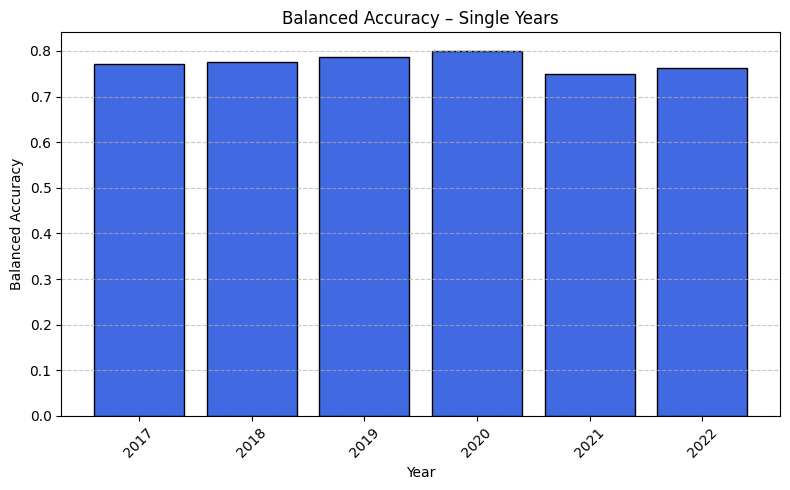

In [3]:
analysis.train_single_years()

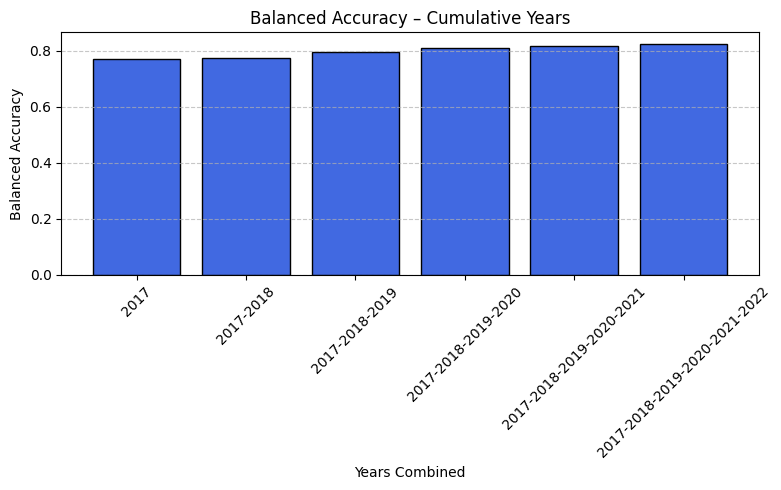

In [4]:
analysis.train_cumulative_years()

<div class="alert-info">

**Interpretation**
- The improvement suggests that the model benefits from a larger and more diverse data base, capturing a wider range of conditions.
- The increase, however, begins to plateau after 2020, implying diminishing returns from adding more years.
- This could mean the model has already learned most relevant patterns by 2020, and additional data adds less new information.

**Conclusion**
- The results show a positive correlation between data quantity and model performance up to a certain point.
- Combining multiple years enhances model robustness and balanced accuracy, but after several years, the performance gains become marginal — suggesting an optimal trade-off between dataset size and computational cost.

</div>

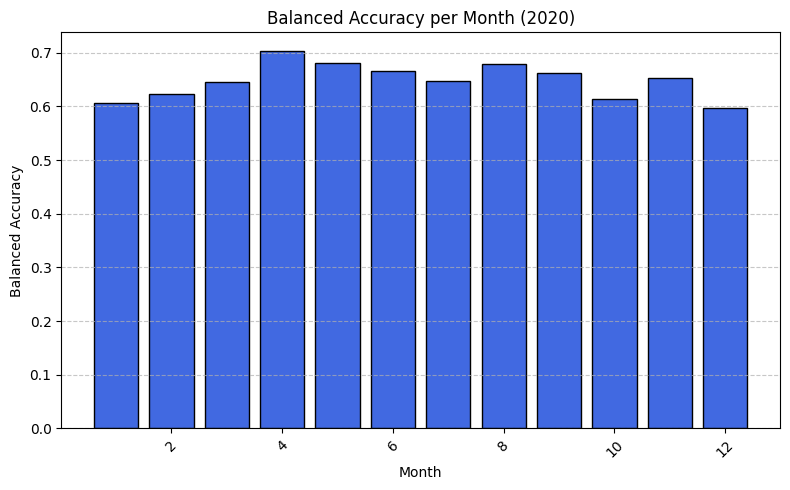

In [5]:
analysis.train_monthly_for_year(2020)

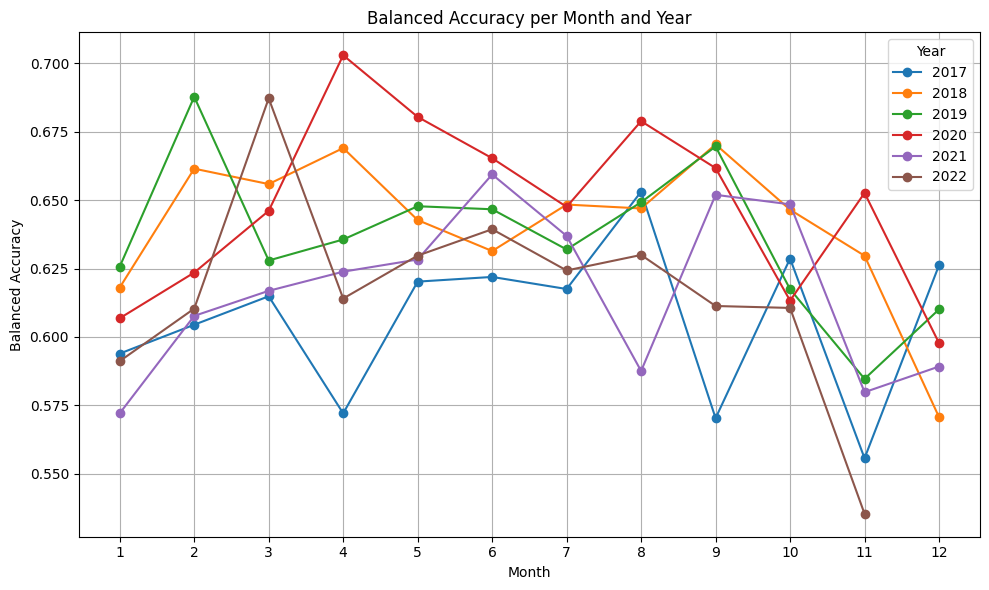

In [6]:
analysis.train_monthly_per_year()

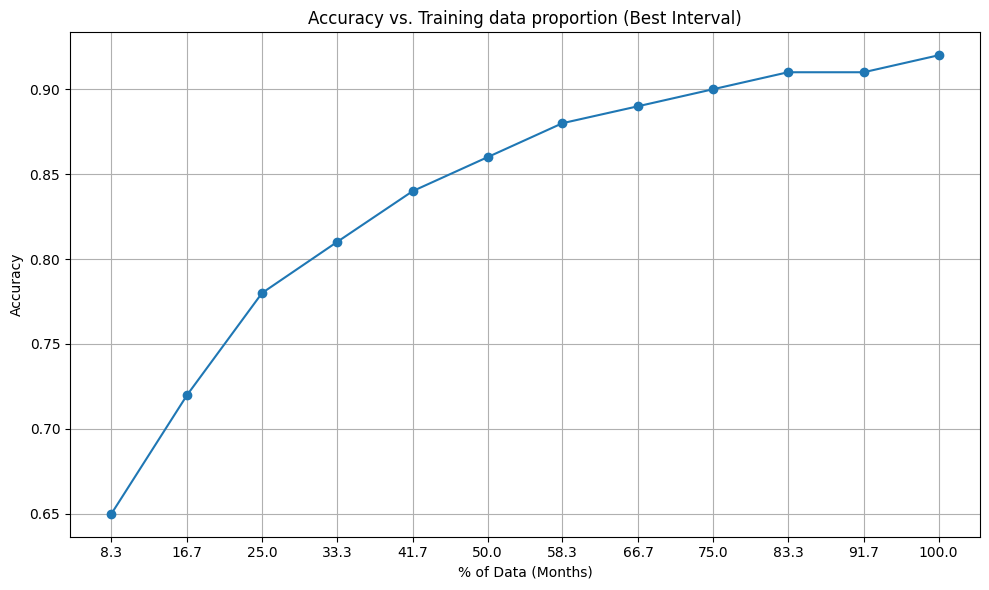

In [ ]:
# Lineplot for Monthly Best Intervals
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker="o", linestyle="-")
plt.xlabel("% of Data (Months)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Training data proportion (Best Interval)")
plt.grid(True)
plt.xticks(x)
plt.tight_layout()
plt.show()

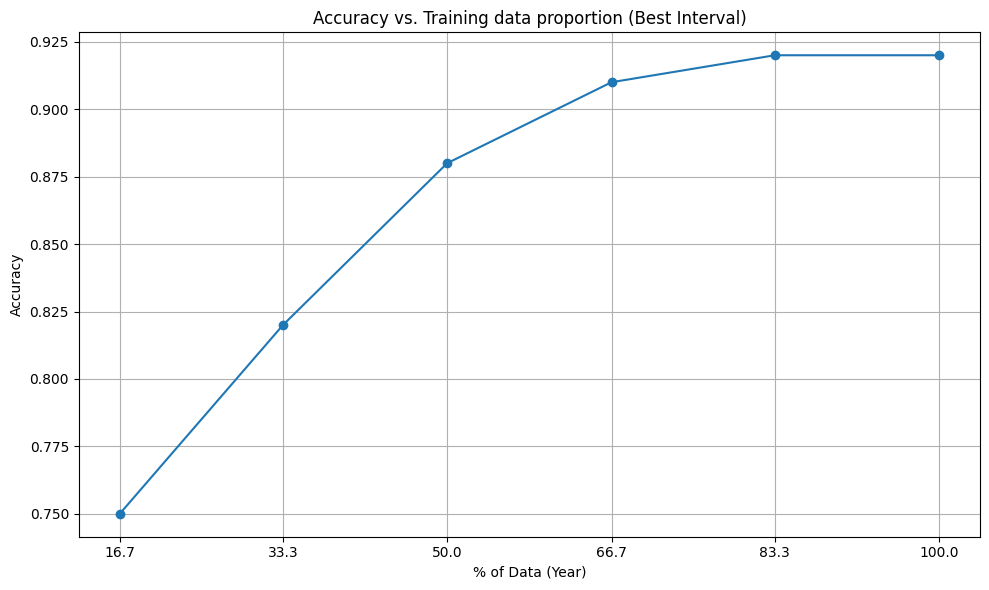

In [ ]:
# Plot for yearly data reduction
x = df_years["% of Training"]
y = df_years["Accuracy"]

plt.figure(figsize=(10, 6))
plt.plot(x, y, marker="o", linestyle="-")
plt.xlabel("% of Data (Year)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Training data proportion (Best Interval)")
plt.grid(True)
plt.xticks(x)
plt.tight_layout()
plt.show()

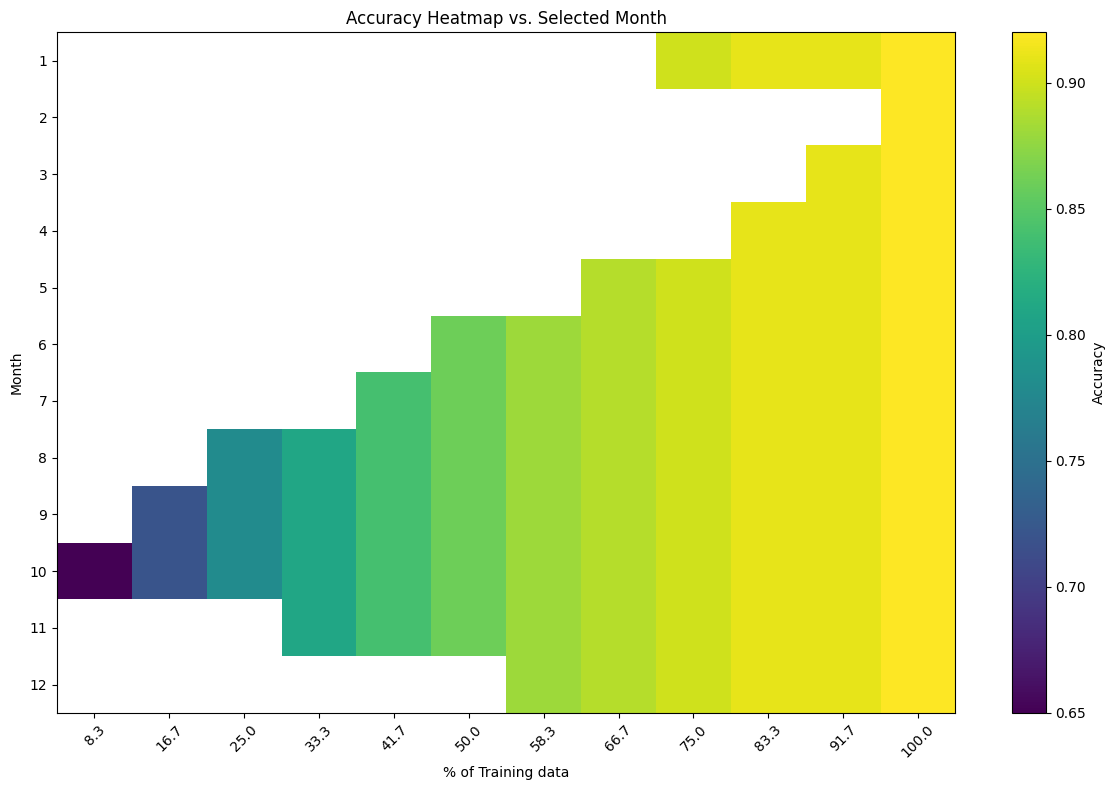

In [ ]:
# Heatmap for Monthly Best Intervals
heatmap_df_accuracy = pd.DataFrame(np.nan, index=df_month.index, columns=range(1, 13))


for index, row in df_month.iterrows():
    accuracy_value = row["Accuracy"]
    for month in row["Bestes_Intervall"]:
        heatmap_df_accuracy.loc[index, month] = accuracy_value


heatmap_df_accuracy.set_index(df_month["% of Training"], inplace=True)

plt.figure(figsize=(12, 8))
plt.imshow(heatmap_df_accuracy.T, cmap="viridis", aspect="auto", interpolation="nearest")
plt.yticks(ticks=range(12), labels=range(1, 13))
plt.xticks(
    ticks=range(len(heatmap_df_accuracy.index)),
    labels=heatmap_df_accuracy.index,
    rotation=45,)
plt.xlabel("% of Training data")
plt.ylabel("Month")
plt.title("Accuracy Heatmap vs. Selected Month")

cbar = plt.colorbar()
cbar.set_label("Accuracy")

plt.tight_layout()
plt.show()

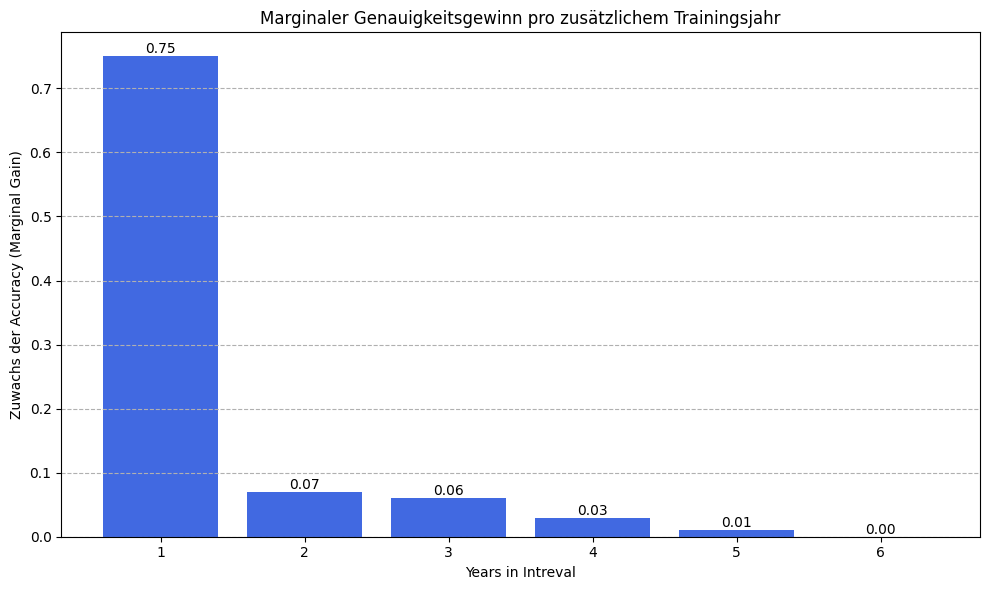

In [ ]:
# train cumulative years - marginal gain plot
df_years["Marginal Gain"] = (df_years["Accuracy"].diff().fillna(df_years["Accuracy"].iloc[0]))

plt.figure(figsize=(10, 6))
bars = plt.bar(
    df_years["Bestes_Intervall"].apply(len).astype(str),
    df_years["Marginal Gain"],
    color="royalblue",)

plt.xlabel("Years in Intreval")
plt.ylabel("Zuwachs der Accuracy (Marginal Gain)")
plt.title("Marginaler Genauigkeitsgewinn pro zusätzlichem Trainingsjahr")
plt.grid(axis="y", linestyle="--")
plt.bar_label(bars, fmt="%.2f")

plt.tight_layout()
plt.show()

<div class="alert-info">

**Yearly Comparison**
- 2017 and 2021 show the lowest overall performance, possibly due to initialization issues or data inconsistencies.
- 2020 stands out with the highest accuracy, reaching up to 0.68–0.70 in several months.
- 2018 and 2019 display relatively stable trends with fewer fluctuations, though without outstanding peaks.
- 2022 starts strong (March–May around 0.67–0.69) but drops sharply towards the end of the year (~0.54 in November), suggesting potential data drift or seasonal changes.

**Monthly Trends**
- Performance tends to be higher between March and May, which could indicate favorable conditions or data characteristics during this period.
- Most years show a decline from October to December, suggesting possible seasonal effects or less representative data late in the year.

</div>

## Disturbed Trees

In [7]:
df_base = pd.read_csv("../../../data/raw/raw_trainset.csv", parse_dates=["time"])
dist_bruner = OldDisturbancePruner()
df = dist_bruner.run(df_base)
df = df[df["species"] != "soil"]

dist_df = df.copy()
dist_df = dist_df[dist_df["disturbance_year"] != 0]
dist_df["year"] = dist_df["time"].dt.year
dist_df["relative_year"] = dist_df["year"] - dist_df["disturbance_year"]
dist_df["species_disturbed"] = (dist_df["species"] == "disturbed").astype(int)

- Negative values mean that the timestamp is before the fault
- Positive values mean that the timestamp is after the fault

In [8]:
plot_distribution(dist_df)

In [9]:
evaluate_time_windows(df_base)

<div class="alert-info">
The evaluation of different time windows around the disturbance event shows that a time window of ±1 years yields the best balanced accuracy.
This suggests that including data from two years before and after the disturbance event provides sufficient context for the model to accurately classify disturbed trees.

If a larger time range were available, additional windows could be evaluated; however, the available data only covers the years 2017 to 2022, which limits the possible window size.
</div>